In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np
import pandas as pd
from scipy.optimize import curve_fit
import scipy

import gm2
import trfp
import plotting_functions as plt2
import analysis_helper as helper
import helper_function_candidates as helper_old

import mu_avg.mu_avg as mu_avg

Welcome to JupyROOT 6.12/04


# Load data, calculate vtms

In [2]:
%%time
# fp_interp_df = helper.root_to_pandas(range(3959,3995), prefix='data1/newg2/DataProduction/Offline/ArtTFSDir/v9_20_00/FieldPlainRootOutput_', tr_run=False)
# tr_interp_df_1 = helper.root_to_pandas([3956], prefix='data1/newg2/DataProduction/Offline/ArtTFSDir/v9_20_00/FieldPlainRootOutput_', tr_run=True)
# tr_interp_df_2 = helper.root_to_pandas([3997], prefix='data1/newg2/DataProduction/Offline/ArtTFSDir/v9_20_00/FieldPlainRootOutput_', tr_run=True)

filename = 'hdf5/60hr.h5'

fp_interp_df = pd.read_hdf(filename, key='fp_df_1')
tr_interp_df_1 = pd.read_hdf(filename, key='tr_df_1')
tr_interp_df_2 = pd.read_hdf(filename, key='tr_df_2')

CPU times: user 127 ms, sys: 1.95 s, total: 2.08 s
Wall time: 6.51 s


In [3]:
%%time
fp_moment_df = helper.calc_moment_df(fp_interp_df)
tr_moment_df_1 = helper.calc_moment_df(tr_interp_df_1)
tr_moment_df_2 = helper.calc_moment_df(tr_interp_df_2)

Finished calculating all moments for 257281 events.      
Finished calculating all moments for 4386 events.
Finished calculating all moments for 4363 events.
CPU times: user 22 s, sys: 51.6 s, total: 1min 13s
Wall time: 15.2 s


In [4]:
%%time
tr_corr_df_1 = helper_old.trolley_footprint_replacement(tr_moment_df_1)
tr_corr_df_2 = helper_old.trolley_footprint_replacement(tr_moment_df_2)

Removing trolley image from station 71.CPU times: user 7.35 s, sys: 4.38 s, total: 11.7 s
Wall time: 5.83 s



### aside for sync offset

In [12]:
sync_offsets, delta_time = helper.sync_offset_calc(tr_corr_df_1, tr_corr_df_2)

In [ ]:
sync_offsets.shape

In [ ]:
print np.mean(sync_offsets[:,0])
print np.std(sync_offsets[:,0])

print np.std(sync_offsets[:,0])/np.sqrt(72)/61.79*1000

2.6594194674589535
43.03964181030836


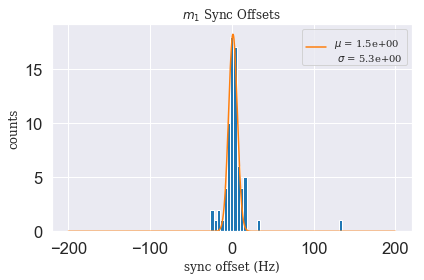

In [21]:
fig1, ax1 = plt.subplots(1,1)

m=3

out = ax1.hist(sync_offsets[:,m-1], bins=40)
def gaussian(x, A, x0, s): return A * np.exp(-(x-x0)**2/(2*s**2))
counts = out[0]
bins = (out[1][1:]+out[1][:-1])/2
fit, _ = curve_fit(gaussian, bins, counts, p0=(20,-10,75))

ax1.plot(np.linspace(-200,200,1000), gaussian(np.linspace(-200,200,1000), *fit),
         label=('$\mu$ = %.1e \n $\sigma$ = %.1e'%(fit[1],fit[2])))

ax1.legend(prop={'size':10, 'family':'serif'})

ax1.set_title('$m_1$ Sync Offsets', fontdict={'size':12, 'family':'serif'})
ax1.set_xlabel('sync offset (Hz)', fontdict={'size':12, 'family':'serif'})
ax1.set_ylabel('counts', fontdict={'size':12, 'family':'serif'})

# ax1.set_xlim(-200,200)

fig1.set_size_inches(6,4)
fig1.tight_layout()

# fig1.savefig('sync_offsets.png', dpi=300)

print fit[2]/2
print fit[2]/2/61.79*1000

###  back to calc

In [5]:
%%time
tr_baseline_1, fp_baseline_1, baseline_time_1, summed_azimuth_1, summed_pts_1 = helper_old.trolley_run_station_average(tr_corr_df_1)
tr_baseline_2, fp_baseline_2, baseline_time_2, summed_azimuth_2, summed_pts_2 = helper_old.trolley_run_station_average(tr_corr_df_2)

CPU times: user 389 ms, sys: 6 ms, total: 395 ms
Wall time: 391 ms


In [6]:
%%time
vtm_df = helper.vtm_calc(fp_moment_df,
                         baseline_time_1, baseline_time_2,
                         tr_baseline_1, tr_baseline_2,
                         fp_baseline_1, fp_baseline_2)

CPU times: user 7.59 s, sys: 15.8 s, total: 23.4 s
Wall time: 4.67 s


In [7]:
### Bin into the agreed upon bins

bins = np.arange(1524384055, 1524639055+200, 100)-50  # bin edges
bin_centers = np.arange(1524384055, 1524639055+100, 100)

vtm_bin_df = vtm_df.groupby(pd.cut(vtm_df.index, bins)).mean()
vtm_bin_df.index = bin_centers

test_df = vtm_bin_df.copy()

azi_avg_df = pd.DataFrame(np.zeros((vtm_bin_df.shape[0],6)),
                         index = vtm_bin_df.index,
                         columns = ['m' + str(m) for m in np.arange(6)+1])

for m in range(5):
    weight = (summed_azimuth_1[:, m] + summed_azimuth_2[:, m])
    total_weight = np.nansum(weight)
    stm_list = ['st'+str(st)+',m'+str(m+1) for st in np.arange(72)]
    azi_avg_df['m'+str(m+1)] = vtm_bin_df[stm_list].multiply(weight).sum(axis=1)/total_weight
print_df = azi_avg_df[['m1','m2','m3','m4','m5']].copy()

In [8]:
def plt_unix_time_to_CST(ax):
    ax.locator_params(axis='x', nbins=5)
    xticks = ax.get_xticks()
    ax.set_xticklabels([pd.to_datetime(tm, unit='s').tz_localize('UTC').tz_convert('US/Central').strftime('%Y-%m-%d\n %H:%M:%S %Z')
                        for tm in xticks], rotation=0, fontdict={'size':12, 'family':'serif'})

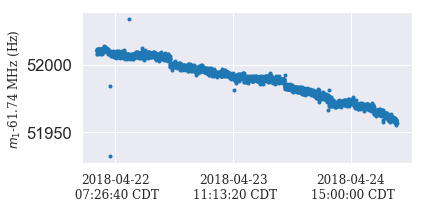

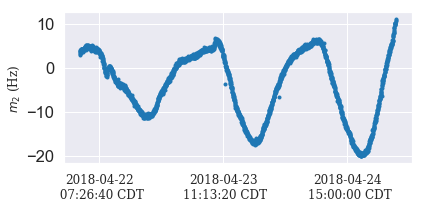

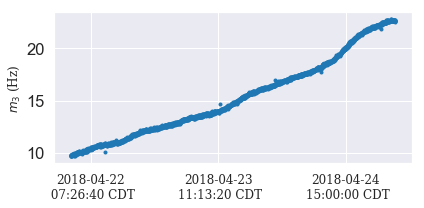

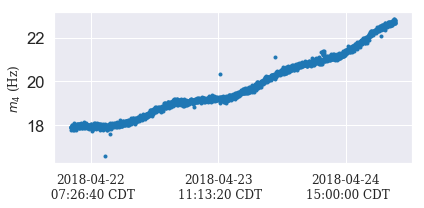

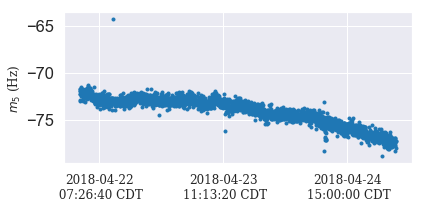

In [11]:
sns.set_style('darkgrid')

fig2, ax2 = plt.subplots(1,1)
m = 1
ax2.plot(print_df.index.values, print_df['m'+str(m)], '.')
ax2.set_ylabel('$m_'+str(m)+'$-61.74 MHz (Hz)', fontdict={'size':12, 'family':'serif'})
plt_unix_time_to_CST(ax2)
fig2.set_size_inches(6,3)
fig2.tight_layout()
fig2.savefig('60hr_m'+str(m)+'.png', dpi=300)


fig3, ax3 = plt.subplots(1,1)
m = 2
ax3.plot(print_df.index.values, print_df['m'+str(m)], '.')
ax3.set_ylabel('$m_'+str(m)+'$ (Hz)', fontdict={'size':12, 'family':'serif'})
plt_unix_time_to_CST(ax3)
fig3.set_size_inches(6,3)
fig3.tight_layout()
fig3.savefig('60hr_m'+str(m)+'.png', dpi=300)

fig4, ax4 = plt.subplots(1,1)
m = 3
ax4.plot(print_df.index.values, print_df['m'+str(m)], '.')
ax4.set_ylabel('$m_'+str(m)+'$ (Hz)', fontdict={'size':12, 'family':'serif'})
plt_unix_time_to_CST(ax4)
fig4.set_size_inches(6,3)
fig4.tight_layout()
fig4.savefig('60hr_m'+str(m)+'.png', dpi=300)

fig5, ax5 = plt.subplots(1,1)
m = 4
ax5.plot(print_df.index.values, print_df['m'+str(m)], '.')
ax5.set_ylabel('$m_'+str(m)+'$ (Hz)', fontdict={'size':12, 'family':'serif'})
plt_unix_time_to_CST(ax5)
fig5.set_size_inches(6,3)
fig5.tight_layout()
fig5.savefig('60hr_m'+str(m)+'.png', dpi=300)

fig6, ax6 = plt.subplots(1,1)
m = 5
ax6.plot(print_df.index.values, print_df['m'+str(m)], '.')
ax6.set_ylabel('$m_'+str(m)+'$ (Hz)', fontdict={'size':12, 'family':'serif'})
plt_unix_time_to_CST(ax6)
fig6.set_size_inches(6,3)
fig6.tight_layout()
fig6.savefig('60hr_m'+str(m)+'.png', dpi=300)

In [ ]:
fig2, ax2 = plt.subplots(1,1)

m = 1

sns.set_style('darkgrid')

ax2.plot(print_df.index.values, print_df['m'+str(m)], '.')
ax2.set_ylabel('$m_'+str(m)+'$-61.74 MHz (Hz)', fontdict={'size':12, 'family':'serif'})
plt_unix_time_to_CST(ax2)

fig2.set_size_inches(6,3)
fig2.tight_layout()

fig2.savefig('60hr_m'+str(m)+'.png', dpi=300)

# Time and azimuthal averaging

## Read in ctags and $\omega_a$ subrun status for time averaging

In [ ]:
### Read in ctag info

subrun_df = pd.read_hdf('old_hdf5/60hr_subrun.h5', key='ctag')
usable_subruns_df = subrun_df[subrun_df['ok']==True].copy()

### Bin by subrun

intervals = []
interval_centers = []
interval_range = []
for ii in range(usable_subruns_df['end_gps'].values.size):
    intervals.append(pd.Interval(usable_subruns_df['start_gps'].values[ii],
                                 usable_subruns_df['end_gps'].values[ii],
                                 closed='both'
                                )
                    )
    interval_centers.append((usable_subruns_df['start_gps'].values[ii] + usable_subruns_df['end_gps'].values[ii])/2)
    interval_range.append(usable_subruns_df['end_gps'].values[ii] - usable_subruns_df['start_gps'].values[ii])
    
intervals = pd.IntervalIndex(intervals)
interval_centers = np.array(interval_centers)
interval_range = np.array(interval_range)

vtm_bin_df = vtm_df.groupby(pd.cut(vtm_df.index, intervals)).mean()
vtm_bin_df['bin_range'] = interval_range
vtm_bin_df['start_gps'] = usable_subruns_df['start_gps'].values

vtm_bin_df = vtm_bin_df.merge(usable_subruns_df[['start_gps', 'ctags']])
vtm_bin_df.index = interval_centers

In [ ]:
subrun_df.head()

In [ ]:
fig, ax = plt.subplots(1,1)

ax.plot(subrun_df['start_gps'].values, subrun_df['ctags'].values, '.')

plt2.plt_unix_time_to_CST(ax)
ax.set_ylabel('ctags')

fig.set_size_inches(12,6)
fig.tight_layout()

## Time average, weighted by ctags in "ok" subruns

In [ ]:
stms = ['st'+str(st)+',m'+str(m+1) for st in range(72) for m in range(6)]
time_avg_series = vtm_bin_df[stms].multiply(vtm_bin_df['ctags'], axis='index').sum()/vtm_bin_df['ctags'].sum()

In [ ]:
time_avg_series

## Naive azimuthal average, weighted by fixed probe station extent

In [ ]:
azi_avg_series = pd.Series(index = ['m' + str(m) for m in np.arange(6)+1])

for m in range(5):
    weight = summed_azimuth_1[:, m] + summed_azimuth_2[:, m]
    
    total_weight = np.nansum(weight)
    stm_list = ['st'+str(st)+',m'+str(m+1) for st in np.arange(72)]
    azi_avg_series['m'+str(m+1)] = time_avg_series[stm_list].multiply(weight).sum()/total_weight

In [ ]:
## naive 2D integral

def _2D_field_map(x,y):  # in mm
    
    m1 = azi_avg_series[0]
    m2 = azi_avg_series[1]
    m3 = azi_avg_series[2]
    
    r = np.sqrt(x**2 + y**2)
    phi = np.arctan2(y,x)
    
    return m1 + m2*r/45*np.cos(phi) + m3*r/45*np.sin(phi)


In [ ]:
def _2D_average_integrand(x,y):
    f = _2D_field_map(x,y)
    g = mu_avg._xy_dist(x, y, 1, 19.4, 45.9, -0.17, 13.5)
    R = 7112 + x
    return R*f*g

def _2D_dist_integrand(x,y):
    return mu_avg._xy_dist(x, y, 1, 19.4, 45.9, -0.17, 13.5)*(7112 + x)

In [ ]:
%%time

opts = {'epsrel':1.0e-3}

num_short = scipy.integrate.nquad(_2D_average_integrand, [[-60,60],[-60,60]], opts=opts)
den_short = scipy.integrate.nquad(_2D_dist_integrand, [[-60,60],[-60,60]], opts=opts)

In [ ]:
print num_short
print den_short

print num_short[0]/den_short[0]/61.79

In [ ]:
print (azi_avg_series[0] + 19.4/45 * azi_avg_series[1] - 0.17/45 *azi_avg_series[2])/61.79

## Analytic form for field  (through m3)

In [ ]:
st_phis = np.array(trfp.STATION_BARCODE_PHI)
st_phis[0:3] -= 360

st_phis = np.append(st_phis, [st_phis[0]+360])
print st_phis

In [ ]:
st_phis = np.array(trfp.STATION_BARCODE_PHI)
st_phis[0:3] -= 360
st_phis = np.append(st_phis, [st_phis[0]+360])
st_phis = st_phis/180*pi

stms = ['st'+str(st)+',m1' for st in range(72)]
m1s = np.append(time_avg_series[stms].values,time_avg_series[stms].values[0])

stms = ['st'+str(st)+',m2' for st in range(72)]
m2s = np.append(time_avg_series[stms].values,time_avg_series[stms].values[0])

stms = ['st'+str(st)+',m3' for st in range(72)]
m3s = np.append(time_avg_series[stms].values,time_avg_series[stms].values[0])

def _xy_field(x, y, m1, m2, m3):  # assume inputs are in mm, fields in Hz
    
    r = np.sqrt(x**2 + y**2)
    phi = np.arctan2(y,x)
    
    return m1 + m2*r/45*np.cos(phi) + m3*r/45*np.sin(phi)

_m1 = scipy.interpolate.CubicSpline(st_phis, m1s, bc_type='periodic')
_m2 = scipy.interpolate.CubicSpline(st_phis, m2s, bc_type='periodic')
_m3 = scipy.interpolate.CubicSpline(st_phis, m3s, bc_type='periodic')

def _field_map(x, y, theta):  # inputs are in mm and radians
    m1 = _m1(theta)
    m2 = _m2(theta)
    m3 = _m3(theta)
    return _xy_field(x, y, m1, m2, m3)

In [ ]:
_field_map(2,2,180)

In [ ]:
_field_map(20,20,pi)

In [ ]:
pi = np.pi

def average_integrand(x, y, theta):  # takes x, y in mm, theta in rad    
    return _field_map(x, y, theta) * mu_avg._xyz_integrand(x, y, theta, 1)

def dist_integrand(x, y, theta): # takes x, y in mm, theta in rad
    return mu_avg._xyz_integrand(x, y, theta, 1)

In [ ]:
%%time
## took ~1 minute
opts = {'epsrel':1.0e-6}
numerator = scipy.integrate.nquad(_field_map, [[-60.,60.],[-60.,60.],[0,2*pi]], opts=opts)

print numerator

In [ ]:
%%time
## took
opts = {'epsrel':1.0e-3}
numerator2 = scipy.integrate.nquad(average_integrand, [[-60,60],[-60,60],[0,2*pi]], opts=opts)

print numerator2

In [ ]:
%%time
## took ~15 minutes
opts = {'epsrel':1.0e-6}
numerator = scipy.integrate.nquad(average_integrand, [[-60,60],[-60,60],[0,2*pi]], opts=opts)

print numerator

In [ ]:
%%time
## took ~10 sec
denominator = scipy.integrate.nquad(dist_integrand, [[-60.,60.],[-60.,60.],[0,2*pi]])

print denominator

In [ ]:
print (numerator[0]/denominator[0])/61.79

In [ ]:
%%time
## takes ~10 seconds

print scipy.integrate.nquad(mu_avg._xyz_integrand, [[-60,60],[-60,60],[0,2*np.pi]], args=[1])

# Legacy code/studies

## Alan studies

In [ ]:
import allantools

fig, ax = plt.subplots(1,1)
for st in range(7):
    stm = 'st'+str(st)+',m1'
    tau, adev, _, _ = allantools.mdev(fp_moment_df[stm].values/61.79, data_type='freq', taus='decade')
    plt.loglog(tau, adev, '.', label=stm)
plt.legend()
fig.set_size_inches(12,8)
fig.tight_layout()

## Sync Offsets

In [ ]:
sync_offsets, delta_t = helper.sync_offset_calc(tr_corr_df_1, tr_corr_df_2)

def gaussian(x, A, x0, sigma): return A*np.exp(-(x-x0)**2/2./sigma**2)

fig, axs = plt.subplots(2,3)
for i in range(2):
    for j in range(3):
        st = 3*i+j
        if st == 5: continue
            
        plt.sca(axs[i,j])
        hist, bins, _ = plt.hist(sync_offsets[:,st], bins=50)
        low, high = axs[i,j].get_xlim()
                
        bins = bins[0:-1] + 0.5*(bins[1]-bins[0])
        coeffs, _ = curve_fit(gaussian, bins, hist, p0=[1., 0., 10.])
        fit = gaussian(np.arange(low, high, 0.1), coeffs[0], coeffs[1], coeffs[2])
        plt.plot(np.arange(low,high,0.1), fit, label=r'$\omega_0$ = '+str(np.round(coeffs[1],1))+'\n$\sigma$ = '+str(np.round(coeffs[2],1)))
        plt.legend(loc=1)
        plt2.plt_set_labels(axs[i,j], 'sync offset (Hz)', '', 'm '+str(st+1))
        
        if st == 0: plt.xlim(-100,100)
        else: plt.xlim(-50,50)


fig.set_size_inches(12,8)
fig.tight_layout()

## Extended trolley averages

In [ ]:
# calculate extended trolley averages

print np.sum(tr_baseline_1*summed_azimuth_1, axis=0)/360

print '\n'

print np.sum(tr_baseline_2*summed_azimuth_2, axis=0)/360

## Legacy time/azimuthal averaging

In [ ]:
### Bin into the agreed upon bins

bins = np.arange(1524384055, 1524641055, 1000)-500  # bin edges
bin_centers = np.arange(1524384055, 1524640055, 1000)

vtm_bin_df = vtm_df.groupby(pd.cut(vtm_df.index, bins)).mean()
vtm_bin_df.index = bin_centers

test_df = vtm_bin_df.copy()

azi_avg_df = pd.DataFrame(np.zeros((test_df.shape[0],6)),
                         index = test_df.index,
                         columns = ['m' + str(m) for m in np.arange(6)+1])

for m in range(5):
    weight = summed_azimuth_1[:, m] + summed_azimuth_2[:, m]
    
    # de-weight station 5 (split into 4 and 6 by distance to each)
    weight[4] += weight[5] * (trfp.STATION_BARCODE_PHI[6]-trfp.STATION_BARCODE_PHI[5])/(trfp.STATION_BARCODE_PHI[6]-trfp.STATION_BARCODE_PHI[4])
    weight[6] += weight[5] * (trfp.STATION_BARCODE_PHI[5]-trfp.STATION_BARCODE_PHI[4])/(trfp.STATION_BARCODE_PHI[6]-trfp.STATION_BARCODE_PHI[4])
    weight[5] = 0
    
    total_weight = np.nansum(weight)
    stm_list = ['st'+str(st)+',m'+str(m+1) for st in np.arange(72)]
    azi_avg_df['m'+str(m+1)] = test_df[stm_list].multiply(weight).sum(axis=1)/total_weight
    
print_df = azi_avg_df[['m1','m2','m3','m5']].copy()/61.79
print_df['m1_err'] = 0.116
print_df['m2_err'] = 0.06
print_df['m3_err'] = 0.06
print_df['m5_err'] = 0.1

print_df = print_df.sort_index(axis='columns')
# print_df.head()
# print_df.to_csv('purcell_60hr_7-31.csv')

In [ ]:
# print all stations

fig, axs = plt.subplots(24,3)

for i in range(24):
    for j in range(3):
        plt.sca(axs[i,j])
        st = i*3 + j
        plt.plot(vtm_bin_df.index.values, vtm_bin_df['st'+str(st)+',m5']/61.79, '.', markersize=1, color='navy')
        plt2.plt_set_labels(axs[i,j], '', 'NS (ppm)', 'st '+str(st))
        plt2.plt_unix_time_to_CST(axs[i,j])

fig.set_size_inches(16, 80)
fig.tight_layout()

## Compare with Rachel

In [ ]:
rachel_m1 = np.loadtxt('rachel_m1_st135.txt')

fig, axs = plt.subplots(24,3)

for i in range(24):
    for j in range(3):
        plt.sca(axs[i,j])
        st = i*3 + j
#         if st == 71: continue
        plt.plot(vtm_bin_df.index.values, vtm_bin_df['st'+str(st)+',m1']/61.79 - rachel_m1[:,st], '.', markersize=1, color='navy')
        plt2.plt_set_labels(axs[i,j], '', 'Dipole (ppm)', 'st '+str(st))
        plt2.plt_unix_time_to_CST(axs[i,j])

fig.set_size_inches(16, 80)
fig.tight_layout()